In [79]:
raw_data <- read.csv("SSL_SCORE_FIRST_1000_0719.csv", sep=",", header=T, strip.white = T, na.strings = c("NA","NaN","","?"))
#Converting the "." in column names to "_"
names(raw_data)<-gsub("\\.", "_", names(raw_data))
cat("The Number of Rows in Initial Data is", nrow(raw_data))
warn=-1

The Number of Rows in Initial Data is 1000

In [80]:
final_features<-raw_data[,c('SSL_SCORE','SSL_SCORE_RANK','PREDICTOR_RAT_AGE_AT_LATEST_ARREST','PREDICTOR_RAT_VICTIM_SHOOTING_INCIDENTS',
                            'PREDICTOR_RAT_VICTIM_BATTERY_OR_ASSAULT','PREDICTOR_RAT_ARRESTS_VIOLENT_OFFENSES','PREDICTOR_RAT_GANG_AFFILIATION', 
                            'PREDICTOR_RAT_NARCOTIC_ARRESTS','PREDICTOR_RAT_TREND_IN_CRIMINAL_ACTIVITY','PREDICTOR_RAT_UUW_ARRESTS','RACE_CODE_CD',
                            'SHORT_LIST')]

In [81]:
complete_data <- final_features[complete.cases(final_features),]

In [82]:
complete_data$SHORT_LIST<-factor(complete_data$SHORT_LIST)
complete_data$PREDICTOR_RAT_AGE_AT_LATEST_ARREST<-factor(complete_data$PREDICTOR_RAT_AGE_AT_LATEST_ARREST)
complete_data$RACE_CODE_CD<-factor(complete_data$RACE_CODE_CD)
complete_data$PREDICTOR_RAT_GANG_AFFILIATION<-factor(complete_data$PREDICTOR_RAT_GANG_AFFILIATION)

In [83]:
n<-nrow(complete_data)

In [84]:
head(complete_data)

SSL_SCORE,SSL_SCORE_RANK,PREDICTOR_RAT_AGE_AT_LATEST_ARREST,PREDICTOR_RAT_VICTIM_SHOOTING_INCIDENTS,PREDICTOR_RAT_VICTIM_BATTERY_OR_ASSAULT,PREDICTOR_RAT_ARRESTS_VIOLENT_OFFENSES,PREDICTOR_RAT_GANG_AFFILIATION,PREDICTOR_RAT_NARCOTIC_ARRESTS,PREDICTOR_RAT_TREND_IN_CRIMINAL_ACTIVITY,PREDICTOR_RAT_UUW_ARRESTS,RACE_CODE_CD,SHORT_LIST
500,1,20-30,0,1,4,1,1,1.0,1,0,1
500,1,less than 20,1,2,2,1,7,0.2,1,0,1
500,1,20-30,4,3,0,1,0,-1.1,0,1,1
500,1,less than 20,0,1,3,1,2,0.1,1,2,1
500,1,less than 20,1,2,6,0,0,0.0,0,0,1
500,1,less than 20,1,1,4,1,1,-0.3,2,0,1


In [85]:
set.seed(1234)
trainIndex = sample(1:n, size = round(0.8*n),replace=FALSE)
train_data = complete_data[trainIndex,]
test_data  = complete_data[-trainIndex,]

In [86]:
nrow(train_data)

[1] 800

In [87]:
nrow(test_data)

[1] 200

In [88]:
library(MatchIt)
library(dplyr)
library(ggplot2)
library(caret)

In [89]:
ctrl <- trainControl(method = "repeatedcv", number = 10, savePredictions = TRUE)

mod_fit <- train(SHORT_LIST ~ PREDICTOR_RAT_AGE_AT_LATEST_ARREST+PREDICTOR_RAT_VICTIM_SHOOTING_INCIDENTS + PREDICTOR_RAT_VICTIM_BATTERY_OR_ASSAULT + 
            PREDICTOR_RAT_ARRESTS_VIOLENT_OFFENSES + PREDICTOR_RAT_GANG_AFFILIATION + PREDICTOR_RAT_NARCOTIC_ARRESTS + PREDICTOR_RAT_TREND_IN_CRIMINAL_ACTIVITY +
            PREDICTOR_RAT_UUW_ARRESTS+RACE_CODE_CD,
            data=train_data, method="glm", family="binomial",
            preProcess="scale",trControl = ctrl, tuneLength = 5)

In [90]:
summary(mod_fit)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1459  -1.1273   0.5818   0.8568   1.6389  

Coefficients:
                                                 Estimate Std. Error z value
(Intercept)                                      -1.78677    0.34593  -5.165
`PREDICTOR_RAT_AGE_AT_LATEST_ARREST30-40`        -0.03829    0.07853  -0.488
`PREDICTOR_RAT_AGE_AT_LATEST_ARRESTless than 20`  0.32238    0.08830   3.651
PREDICTOR_RAT_VICTIM_SHOOTING_INCIDENTS           0.31414    0.10599   2.964
PREDICTOR_RAT_VICTIM_BATTERY_OR_ASSAULT           0.59447    0.12422   4.785
PREDICTOR_RAT_ARRESTS_VIOLENT_OFFENSES            0.82896    0.12404   6.683
PREDICTOR_RAT_GANG_AFFILIATION1                  -0.10885    0.09198  -1.183
PREDICTOR_RAT_NARCOTIC_ARRESTS                    0.63337    0.11245   5.633
PREDICTOR_RAT_TREND_IN_CRIMINAL_ACTIVITY          0.08460    0.08790   0.962
PREDICTOR_RAT_UUW_ARRESTS                         0.17118    0.09882   1.732
RACE_CODE_CD

In [91]:
predicted_values<-predict(mod_fit, newdata=test_data,type= "prob")[,2]  

In [92]:
library(ROCR)
pred <- prediction((predicted_values),(test_data$SHORT_LIST))

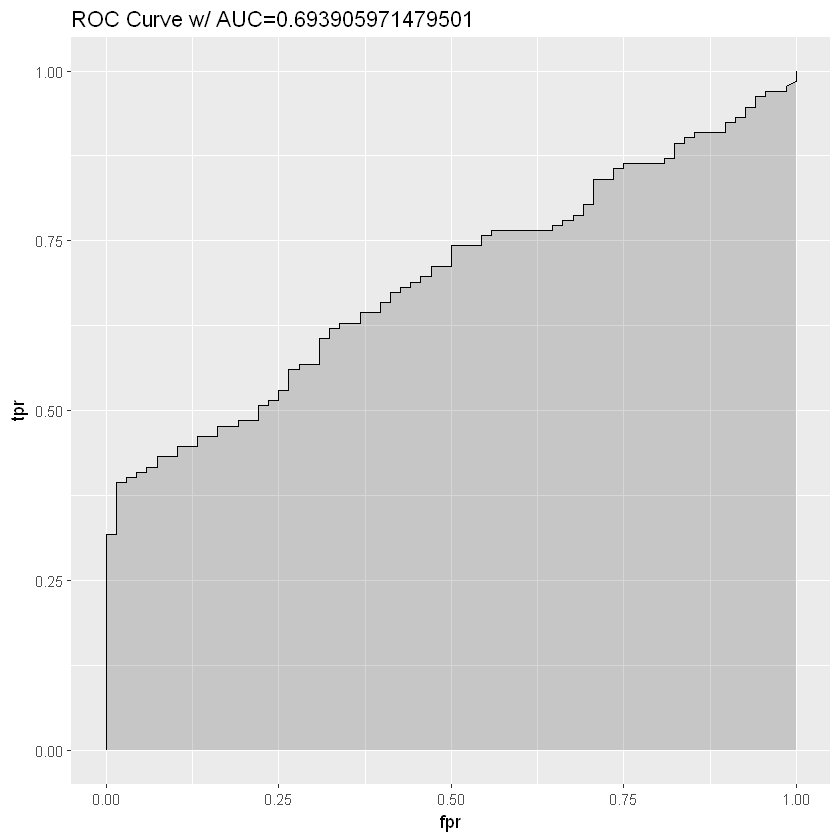

In [93]:
perf <- performance(pred, measure = "tpr", x.measure = "fpr")
auc <- performance(pred, measure = "auc")
auc <- auc@y.values[[1]]

roc.data <- data.frame(fpr=unlist(perf@x.values),
                       tpr=unlist(perf@y.values),
                       model="RF")

ggplot(roc.data, aes(x=fpr, ymin=0, ymax=tpr)) +
  geom_ribbon(alpha=0.2) +
  geom_line(aes(y=tpr)) +
  ggtitle(paste0("ROC Curve w/ AUC=", auc))


In [94]:
mod_match <- matchit(RACE_CODE_CD ~ PREDICTOR_RAT_AGE_AT_LATEST_ARREST+PREDICTOR_RAT_VICTIM_SHOOTING_INCIDENTS + PREDICTOR_RAT_VICTIM_BATTERY_OR_ASSAULT + 
            PREDICTOR_RAT_ARRESTS_VIOLENT_OFFENSES + PREDICTOR_RAT_GANG_AFFILIATION + PREDICTOR_RAT_NARCOTIC_ARRESTS + PREDICTOR_RAT_TREND_IN_CRIMINAL_ACTIVITY +
            PREDICTOR_RAT_UUW_ARRESTS,
                     method = "nearest", data = complete_data)

In [95]:
mod_match


Call: 
matchit(formula = RACE_CODE_CD ~ PREDICTOR_RAT_AGE_AT_LATEST_ARREST + 
    PREDICTOR_RAT_VICTIM_SHOOTING_INCIDENTS + PREDICTOR_RAT_VICTIM_BATTERY_OR_ASSAULT + 
    PREDICTOR_RAT_ARRESTS_VIOLENT_OFFENSES + PREDICTOR_RAT_GANG_AFFILIATION + 
    PREDICTOR_RAT_NARCOTIC_ARRESTS + PREDICTOR_RAT_TREND_IN_CRIMINAL_ACTIVITY + 
    PREDICTOR_RAT_UUW_ARRESTS, data = complete_data, method = "nearest")

Sample sizes:
          Control Treated
All           891      13
Matched        13      13
Unmatched     878       0
Discarded       0       0


In [96]:
matched <- match.data(mod_match)

[1] "To identify the units, use first mouse button; to stop, use second."


integer(0)

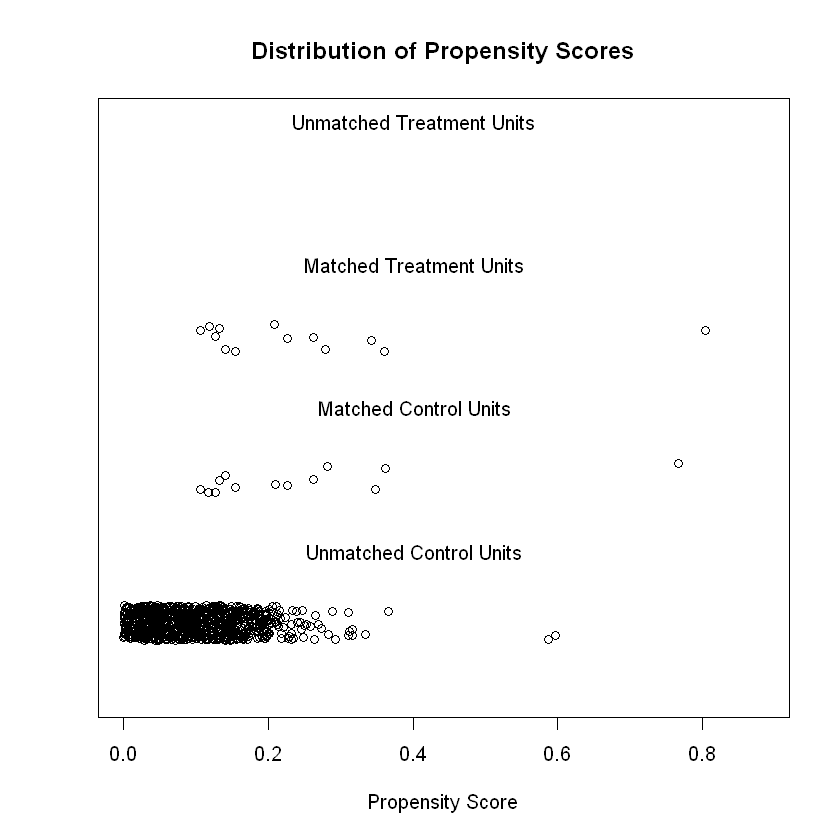

In [97]:
plot(mod_match, type = "jitter")

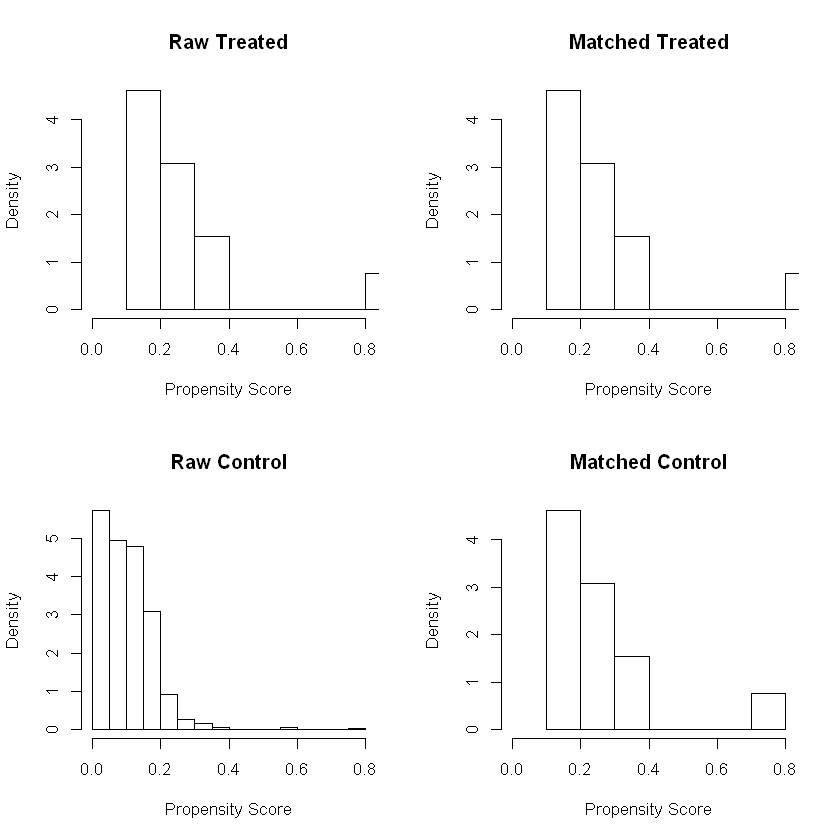

In [98]:
plot(mod_match, type = "hist")

In [99]:
warn=-1
ctrl <- trainControl(method = "repeatedcv", number = 10, savePredictions = TRUE)

mod_fit_PSM <- train(SHORT_LIST ~ PREDICTOR_RAT_AGE_AT_LATEST_ARREST+PREDICTOR_RAT_VICTIM_SHOOTING_INCIDENTS + PREDICTOR_RAT_VICTIM_BATTERY_OR_ASSAULT + 
            PREDICTOR_RAT_ARRESTS_VIOLENT_OFFENSES + PREDICTOR_RAT_GANG_AFFILIATION + PREDICTOR_RAT_NARCOTIC_ARRESTS + PREDICTOR_RAT_TREND_IN_CRIMINAL_ACTIVITY +
            PREDICTOR_RAT_UUW_ARRESTS+RACE_CODE_CD,
            data=matched, method="glm", family="binomial",
            preProcess="scale",trControl = ctrl, tuneLength = 5)


Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
"These variables have zero variances: PREDICTOR_RAT_AGE_AT_LATEST_ARREST30-40, PREDICTOR_RAT_GANG_AFFILIATION1, RACE_CODE_CD2"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
"These variables have zero variances: PREDICTOR_RAT_AGE_AT_LATEST_ARREST30-40, PREDICTOR_RAT_GANG_AFFILIATION1, RACE_CODE_CD2"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
"These variables have zero v

In [100]:
summary(mod_fit_PSM)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0827   0.0000   0.0000   0.3382   1.0774  

Coefficients: (3 not defined because of singularities)
                                                   Estimate Std. Error z value
(Intercept)                                         2.63470    8.95542   0.294
`PREDICTOR_RAT_AGE_AT_LATEST_ARREST30-40`                NA         NA      NA
`PREDICTOR_RAT_AGE_AT_LATEST_ARRESTless than 20`   -3.68913    5.27591  -0.699
PREDICTOR_RAT_VICTIM_SHOOTING_INCIDENTS            31.10436 5656.76067   0.005
PREDICTOR_RAT_VICTIM_BATTERY_OR_ASSAULT            -0.01444    2.69237  -0.005
PREDICTOR_RAT_ARRESTS_VIOLENT_OFFENSES              3.85642    3.93512   0.980
PREDICTOR_RAT_GANG_AFFILIATION1                          NA         NA      NA
PREDICTOR_RAT_NARCOTIC_ARRESTS                     -0.42098    3.14008  -0.134
PREDICTOR_RAT_TREND_IN_CRIMINAL_ACTIVITY            3.26209    2.86035   1.140
PREDICTOR_RAT_UUW_ARRESTS   